# Humanitarian Data Category Predictor
## Last Updated: March 2021

### Ryan ARIAS DELAFOSSE

## Objective

The objective of this framework is to detect, classify, and recommend a category of data in the context of natural disasters and humanitarian emergencies. The categories of humanitarian data collected during an onset of a crisis is usually limited to the most immediate needs of a population. By identifying these categories and classifying incoming data, humanitarians and information managers can focus on collecting, cleaning, and utilizing information while automatically classified data is analyzed and mapped.

The notebook may change as I try new methodologies, datasets, and models.

## Methodology

Over 2,000 datasets were scraped from the Humanitarian Data Exchange (HDX). The datasets pulled had Humanitarian Exchange Language (HXL) tags, which identify the type of data. This data was processed and distilled down to a certain number of tags that are only relevant to rapid needs assessments. These tags were then turned into categories for a training set for our model.

Word embeddings were created using fastText, an NLP library created by Facebook. An MLP model is then trained using these word embeddings.

Assorted rapid needs assessment datasets are then tested to see the model's accuracy.

In [1]:
## Load Libraries

In [2]:
import pandas as pd
from os import path
import re, string
from fasttext import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

## Preprocessing Data 

This program pre-processes the data consisting of the headers of HDX datasets.
The idea is to prepare the strings for the word embedding model which works best if words are separated by 
blank space. Thus the main pre-processing steps are to split the strings on punctuation characters, split on
single capital letters, lowercase everything and remove excess whitespace.

Input: .xlsx file containing at least the columns 'Hashtag' and 'Text header'. It is recommended that the input file
be deduplicated so as not to include repetitions of identical file structures.

Output: .csv file where each row contains a hashtag and a cleaned header string

In [3]:
def split_uppercase(value):     # split strings on uppercase
    return re.sub(r'([A-Z])', r' \1', str(value))


def lower_case_cond(value):     # lowercase only words which are all uppercase
    word_list = value.split()
    for i, word in enumerate(word_list):
        if word.isupper():
            word_list[i] = word.lower()
    return ' '.join(word_list)


def split_punctuation(value):   # split strings on punctuation characters:
    table = str.maketrans(string.punctuation, " " * len(string.punctuation))
    return value.translate(table)


def remove_whitespace(value):
    return ' '.join(value.split())

In [4]:
input_file = 'inputs/full_dataset.csv'
output_file = 'training_data.csv'

d = path.dirname("D:\Files\Google Drive\Research\Humanitarian Machine Learning\ESiLV Model")

In [5]:
df = pd.read_csv(input_file)

In [6]:
df = df[['Header','Tag']]

In [7]:
label = df[['Tag']]

df['Header'] = df['Header'].map(lambda x: str(x))
df['Header'] = df['Header'].map(lambda x: split_punctuation(x))
df['Header'] = df['Header'].map(lambda x: lower_case_cond(x))
df['Header'] = df['Header'].map(lambda x: split_uppercase(x))
df['Header'] = df['Header'].map(lambda x: remove_whitespace(x))
df['Header'] = df['Header'].map(lambda x: x.lower())

header = df[['Header']] 

In [8]:
training_data = pd.concat([label, header], axis=1)

In [9]:
training_data.head()

,Tag,Header
0,description,hashtag one liner
1,description,hashtag long description
2,status,release status
3,meta,first release
4,meta,category


We can export this training data if it is ever needed again.

In [10]:
training_data.to_csv("training_data.csv")
# ^^
# For some reason sometimes creates more than two columns on export.

## Extra Features

This program extracts features from the cleaned HXL headers by converting them to word embeddings.
The word embeddings used here are 300-dim fastText embeddings. They are loaded from a large (~10GB) fastText model
which can be downloaded here: https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip
Note that the .zip contains a .bin file and a .vec file. These are different formats for storing the fastText model,
use the .bin file whenever possible.

Input: .csv file where each row contains a hashtag and a cleaned header string

Output: .csv file containing hashtags, header strings and their corresponding word embeddings
NOTE: this output formatting is not ideal and currently has to be handled ad hoc in the program which trains the ML 
model. It should be changed to something more suitable for storing large vectors, e.g. .xml, .pickle, etc.

In [11]:
input_file = 'training_data.csv'
output_file = 'wordembedding_data.csv'
pretrained_fasttext_model = 'wikibin/wiki.en.bin'   # You have to download the fasttext english which is quite large (10gb)

In [12]:
# Load the fastText model
fastText_model = load_model(pretrained_fasttext_model)
print("Pre-trained model loaded successfully!\n")

Pre-trained model loaded successfully!



In [13]:
# Read the cleaned data
df = pd.read_csv(input_file , delimiter=',', encoding='utf-8')

Sometimes when the .csv file is written, it writes with more than two columns. If this happens there should be a code that drops every other column than the first two. There should only "Hashtag" and "Text header"

In [14]:
df.head()

,Unnamed: 0,Tag,Header
0,0,description,hashtag one liner
1,1,description,hashtag long description
2,2,status,release status
3,3,meta,first release
4,4,meta,category


In [15]:
df['Tag'].value_counts()

affected            3704
country             2226
date                1755
year                1177
indicator           1007
date (start)         755
date (end)           754
admin1 name/code     504
description          477
sector               446
status               415
population           413
activity             204
location             170
latitude             167
longitude            167
id                   163
admin2 name/code     154
cluster              148
admin3 name/code     116
meta                  72
inneed                38
targeted              25
reached               11
admin4 name/code       1
Name: Tag, dtype: int64

In [16]:
# Very easy for major problems to happen here. Had to clean this data - there were spaces where they shouldn't be.
df["Header"] = df["Header"].map(lambda x: re.sub(' +', ' ', str(x)))

In [17]:
# Get a vector representation of each header
df["Word_embedding"] = df["Header"].map(lambda x: fastText_model.get_sentence_vector(str(x)))
print("Word embeddings extracted!\n")

Word embeddings extracted!



In [18]:
df.head()

,Unnamed: 0,Tag,Header,Word_embedding
0,0,description,hashtag one liner,"[-0.07998582, 0.021870561, -0.042457223, 0.005..."
1,1,description,hashtag long description,"[-0.017826393, 0.042394362, -0.05612909, 0.036..."
2,2,status,release status,"[0.010698192, -0.02164933, 0.011707802, -0.001..."
3,3,meta,first release,"[-0.02181292, -0.021237206, 0.0049731927, -0.0..."
4,4,meta,category,"[-0.16172124, -0.0065363646, 0.050074376, 0.03..."


In [19]:
# Save the vectorized data
df.to_csv(output_file)

## Create MLP Classification Model

This program trains an MLP classifier to predict HXL hashtags.
If you are training a classifier on a new dataset, it is adviced to first tune the parameters of the model.

Input: .csv file containing hashtags, header strings and their corresponding word embeddings from extract_features.py

Output: A pickled MLP classifier. Also the model is tested on a test set, the classification accuracy is printed 
along with the confusion matrix.

TO ADD: Adjusting Parameters

In [20]:
# Adjusting Parameters go here

Run the model

In [21]:
def format_embeddings(embedding):
    """Fix some formatting issues from feature extraction"""
    embedding = embedding.replace('\r\n', '')
    embedding = embedding.replace('[', '')
    embedding = embedding.replace(']', '')
    return np.fromstring(embedding, dtype=float, sep=' ').tolist()

input_file = 'wordembedding_data.csv'
output_file = 'MLPclassifier.pkl'

# Read data
df = pd.read_csv(input_file, delimiter=',', encoding='utf-8')

df['Class'] = df['Tag']
df['Word_embedding'] = df['Word_embedding'].map(lambda x: format_embeddings(x))

# Remove infrequent classes
threshold = 5   # include only rows with at least this many points
class_count = df['Class'].value_counts()
removal = class_count[class_count <= threshold].index
df['Class'] = df['Class'].replace(removal, np.nan)
df = df.dropna()

df = df[['Class', 'Word_embedding']].copy()
df_labels = df.Class.unique()
df_labels = np.sort(df_labels, axis=-1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Word_embedding'], df['Class'], test_size=0.33, random_state=0)


# Train the classifier with the parameters as specified
clf = MLPClassifier(activation='relu', alpha=0.001, epsilon=1e-08, hidden_layer_sizes=150, solver='adam')
clf.fit(X_train.values.tolist(), y_train.values.tolist())
test_score = clf.score(X_test.tolist(), y_test.tolist())
print("Classification accuracy on test set: %s" %test_score)

Classification accuracy on test set: 0.9181580534888397


Confusion Matrix

C:\Users\Ryan\anaconda3\envs\humanitarianML\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['activity' 'admin1 name/code' 'admin2 name/code' 'admin3 name/code'
 'affected' 'cluster' 'country' 'date' 'date (end)' 'date (start)'
 'description' 'id' 'indicator' 'inneed' 'latitude' 'location' 'longitude'
 'meta' 'population' 'reached' 'sector' 'status' 'targeted' 'year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


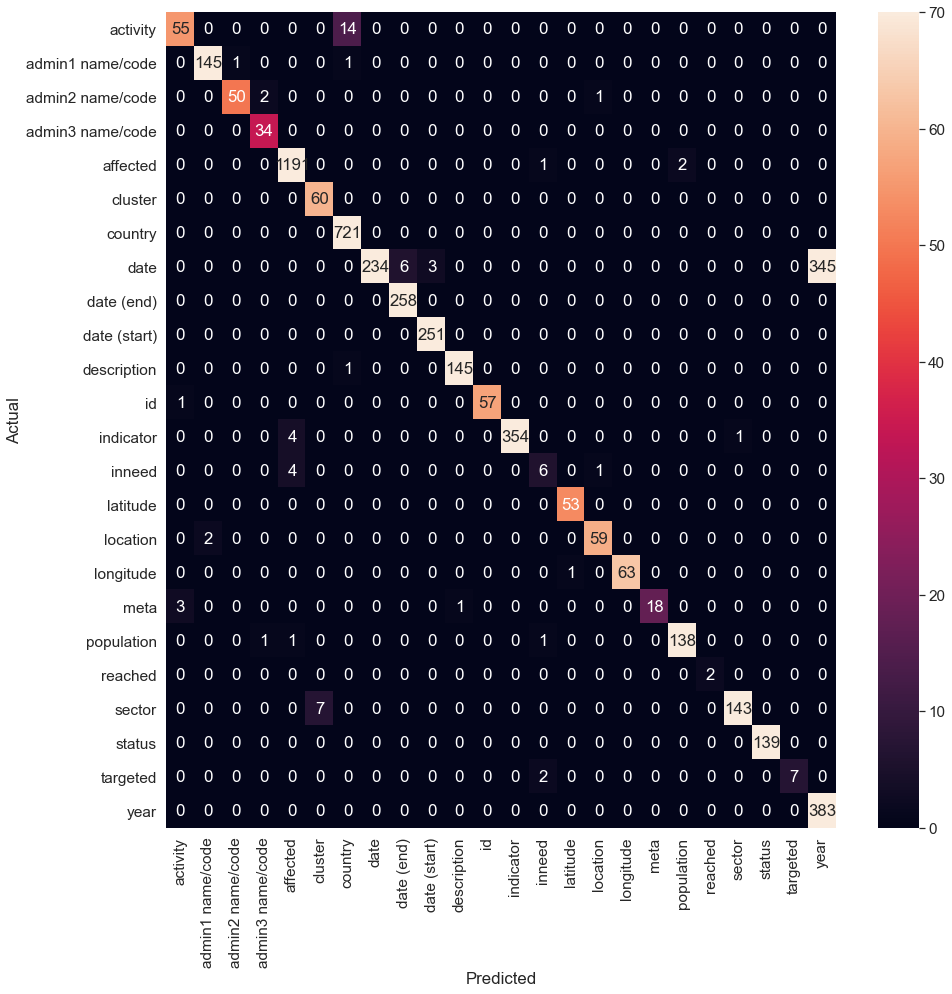

In [39]:
y_pred = clf.predict(X_test.values.tolist())
confmatrix = confusion_matrix(y_test.values.tolist(), y_pred, df_labels)
fig, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.4) 
sns.heatmap(confmatrix, annot=True, 
            fmt='d', 
            xticklabels=df_labels, yticklabels=df_labels,
            vmax=70)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
# Save the trained classifier for later use
pickle.dump(clf, open(output_file, 'wb'))

## Tags Dataset with Model

This program reads an untagged dataset and tags it using a trained classifier.

Input: Raw .xls file without tags from the HDX.
NOTE: This PoC has been written for .xlsx files but could easily be rewritten to handle other formats

Output: The same .xls but with an additional row containing the predicted hashtags

In [24]:
def split_punctuation(value): # split strings on punctuation characters:
    table = str.maketrans(string.punctuation, " " * len(string.punctuation))
    return value.translate(table)


def lower_case(value): # lowercase only words which are all uppercase
    word_list = value.split()
    for i, word in enumerate(word_list):
        if word.isupper():
            word_list[i] = word.lower()
    return ' '.join(word_list)


def split_uppercase(value): # split strings on uppercase
    return re.sub(r'([A-Z])', r' \1', str(value))


def remove_whitespace(value):
    return ' '.join(value.split())


def format_header(header):
    header = str(header)
    header = split_punctuation(header)
    header = lower_case(header)
    header = split_uppercase(header)
    header = remove_whitespace(header)
    header = header.lower()
    return header

Test 1 Syrian Dataset

In [25]:
input_file = "data.xls"

# No neeed to do this a second time if ran in modeling section abov
#pretrained_fasttext_model = 'wikibin/wiki.en.bin' 

df = pd.read_excel(input_file)

# Preprocessing
headers = list(df)
headers = [format_header(x) for x in headers]
headers

['description',
 'country',
 'adm1',
 'adm2',
 'adm3',
 'adm4',
 'latitude',
 'longitude',
 'name',
 'pcode']

In [26]:
# Load word embedding model for feature generation
# No neeed to do this a second time if ran in modeling section above
# fastText_model = load_model(pretrained_fasttext_model)
print("Pre-trained model loaded successfully!\n")

Pre-trained model loaded successfully!



In [27]:
# Convert dataset headers into word embeddings
headers = [fastText_model.get_sentence_vector(x).tolist() for x in headers]

In [28]:
# Load the pre-trained classifier
clf = pickle.load(open("MLPclassifier.pkl", 'rb'))

In [29]:
# Predict tags
tags = clf.predict(headers)

In [30]:
# Insert row of tags into the dataset
df.loc[-1] = tags
df.index = df.index + 1  # shifting index
df.sort_index(inplace=True)

In [31]:
df.head()

,Description,Country,ADM1,ADM2,ADM3,ADM4,Latitude,Longitude,Name,PCODE
0,description,country,admin1 name/code,admin2 name/code,admin3 name/code,indicator,latitude,longitude,country,admin2 name/code
1,IDP Camp,Syria,Al Qunaytirah,Al Qunaytirah,Al Qunaytirah,Breiqa,33.039,35.86,Burayqah IDP Camp,SY140000C6269
2,IDP Camp,Syria,As Suwayda',As Suwayda',As Suwayda',Kherba,32.583,36.439,Kharaba IDP Camp,SY130000C6150
3,IDP Camp,Syria,As Suwayda',As Suwayda',As Suwayda',Kherba,32.588,36.447,Kharaba Church East IDP Camp,SY130000C6150
4,IDP Camp,Syria,Damascus Countryside,Duma,Sabe Byar,Sabe Byar,33.311,38.674,Ruqban Border Crossing IDP Camp,SY030202C2345


TEST 2

## Wordcloud

This program generates wordclouds of the table headers associated with different HXL hashtags.

Input: .csv file containing at least the columns 'Hashtag' and 'Text header'

Output: A set of .png figures of the word clouds for the hashtags

In [33]:
import wordcloud

input_file = "training_data.csv"  

d = path.dirname("D:/Files/Google Drive/Research/tag-predict-master/")

In [34]:
# Read and process data
df = pd.read_csv(input_file)
df.columns = df.columns.str.lower()
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, bytes)) else x)
df.columns = cols

In [35]:
df.head()

,unnamed:_0,tag,header
0,0,description,hashtag one liner
1,1,description,hashtag long description
2,2,status,release status
3,3,meta,first release
4,4,meta,category


In [36]:
df["header"] = df["header"].str.lower()
df["header"] = df["header"].replace('_', ' ', regex=True)

<ipython-input-37-53cfbc4ec63c>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


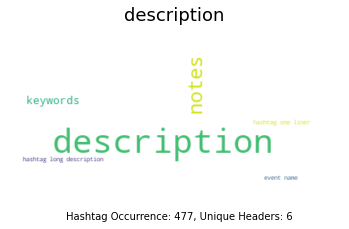

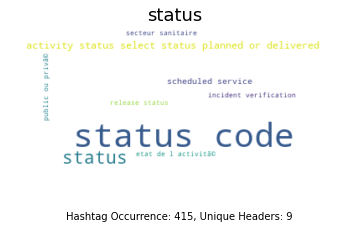

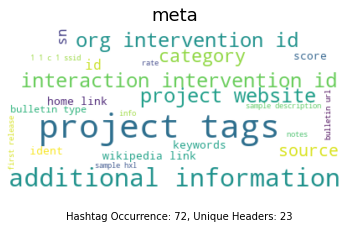

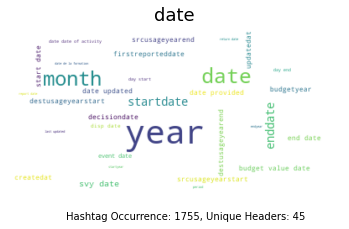

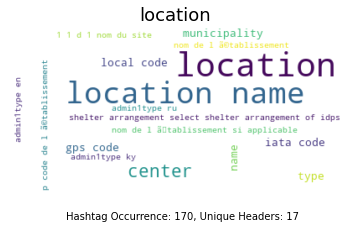

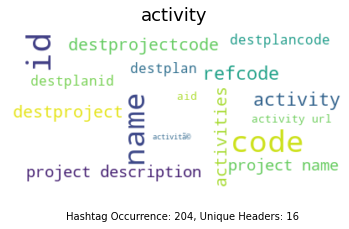

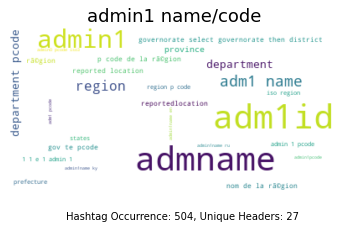

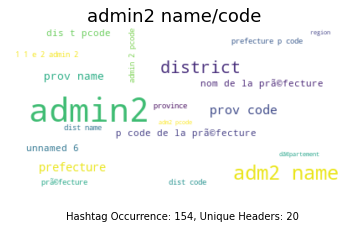

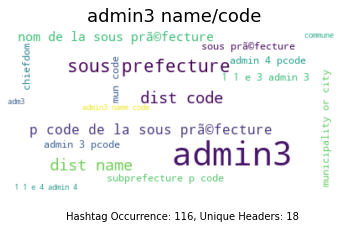

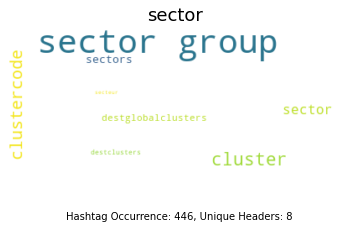

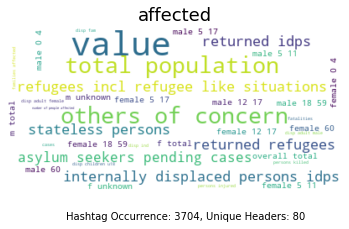

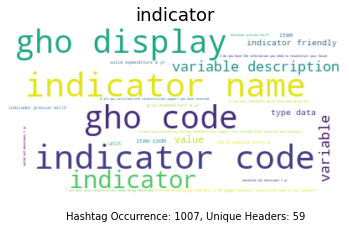

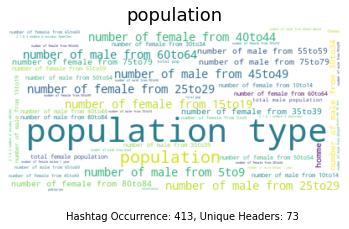

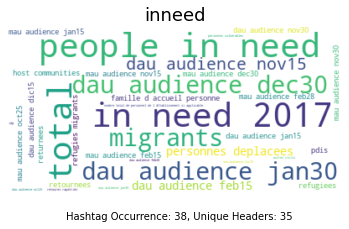

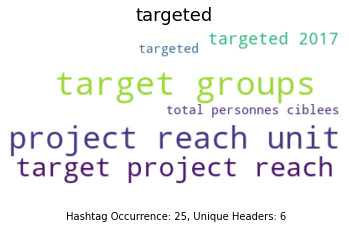

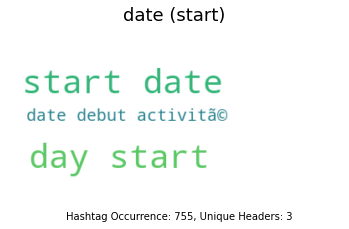

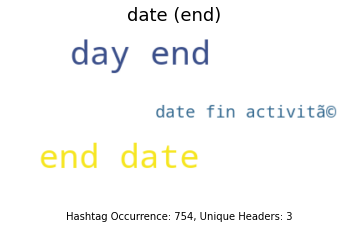

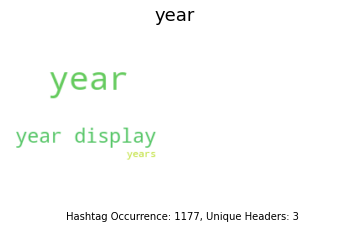

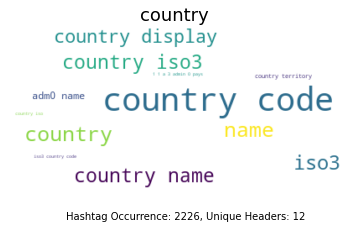

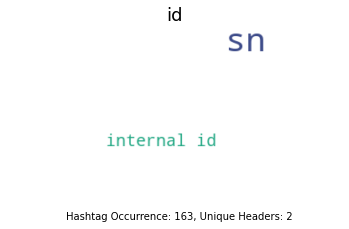

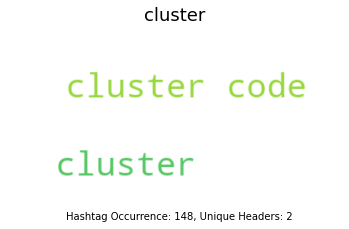

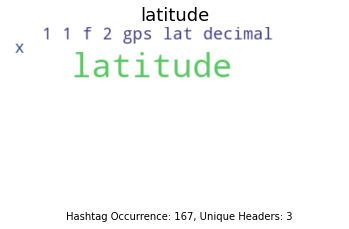

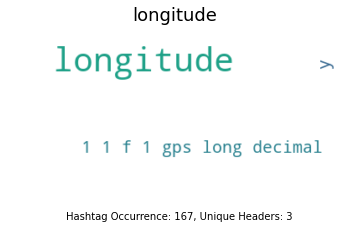

In [37]:
tagList = df.tag.unique()   # List all unique hashtags in the dataset
output = pd.DataFrame(columns=['tag','Count','Unique headers','Score'])

i=0
for tag in tagList:
    # Compute various statistics
    df_tag = df.loc[df['tag'] == tag]
    count = df_tag.shape[0]
    unique = len(df_tag['header'].unique())
    output.loc[i] = [tag, count, unique, unique/count]
    i+=1

output_top100 = output.loc[output["Count"]>20]  # Create word clouds only for the tags with >20 occurrences

for index, row in output_top100.iterrows():
    # Create wordclouds
    hashtag = row['tag']
    df_wc = df.loc[df['tag'] == hashtag]
    tuples = tuple([tuple(x) for x in df_wc.header.value_counts().reset_index().values])
    tuples = dict(tuples)
    cloud = wordcloud.WordCloud(background_color="white", max_font_size=40)
    cloud.generate_from_frequencies(tuples)
    plt.figure()
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.text(70,230,"Hashtag Occurrence: %s, Unique Headers: %s" %(row['Count'], row['Unique headers']))
    plt.title(hashtag, fontsize=18)
    #plt.savefig(path.join(d, "wordcloud", "wordcloud%s.png" %hashtag))
    #plt.close()